#### What is this notebook?

This notebook is made for running parameter experiments. Since I have taken out the hard coded numerical variables, I gathered it in a `parameters.json` file and here.  When the model is basically done, you can run the experiments here rather easily.

#### Cell 1: Manage file system


Simulation Year 0
village has 0 new born.

Simulation Year 1
village has 4 new born.

Simulation Year 2
village has 19 new born.

Simulation Year 3
village has 17 new born.

Simulation Year 4
village has 11 new born.

Simulation Year 5
village has 8 new born.

Simulation Year 6
village has 3 new born.

Simulation Year 7
village has 4 new born.

Simulation Year 8
village has 5 new born.

Simulation Year 9
village has 6 new born.

Simulation Year 10
village has 10 new born.

Simulation Year 11
village has 5 new born.

Simulation Year 12
village has 4 new born.

Simulation Year 13
village has 11 new born.
Household 5 migrated to (4, 6).
empty_land_cells [((4, 6), {'quality': 6.106015266589205, 'occupied': True, 'max_capacity': 20, 'recovery_rate': 0.03, 'fallow': False, 'fallow_timer': 0, 'fishing': False})]

Simulation Year 14
village has 24 new born.

Simulation Year 15
village has 15 new born.

Simulation Year 16
village has 14 new born.

Simulation Year 17
village has 7 new born.

Si

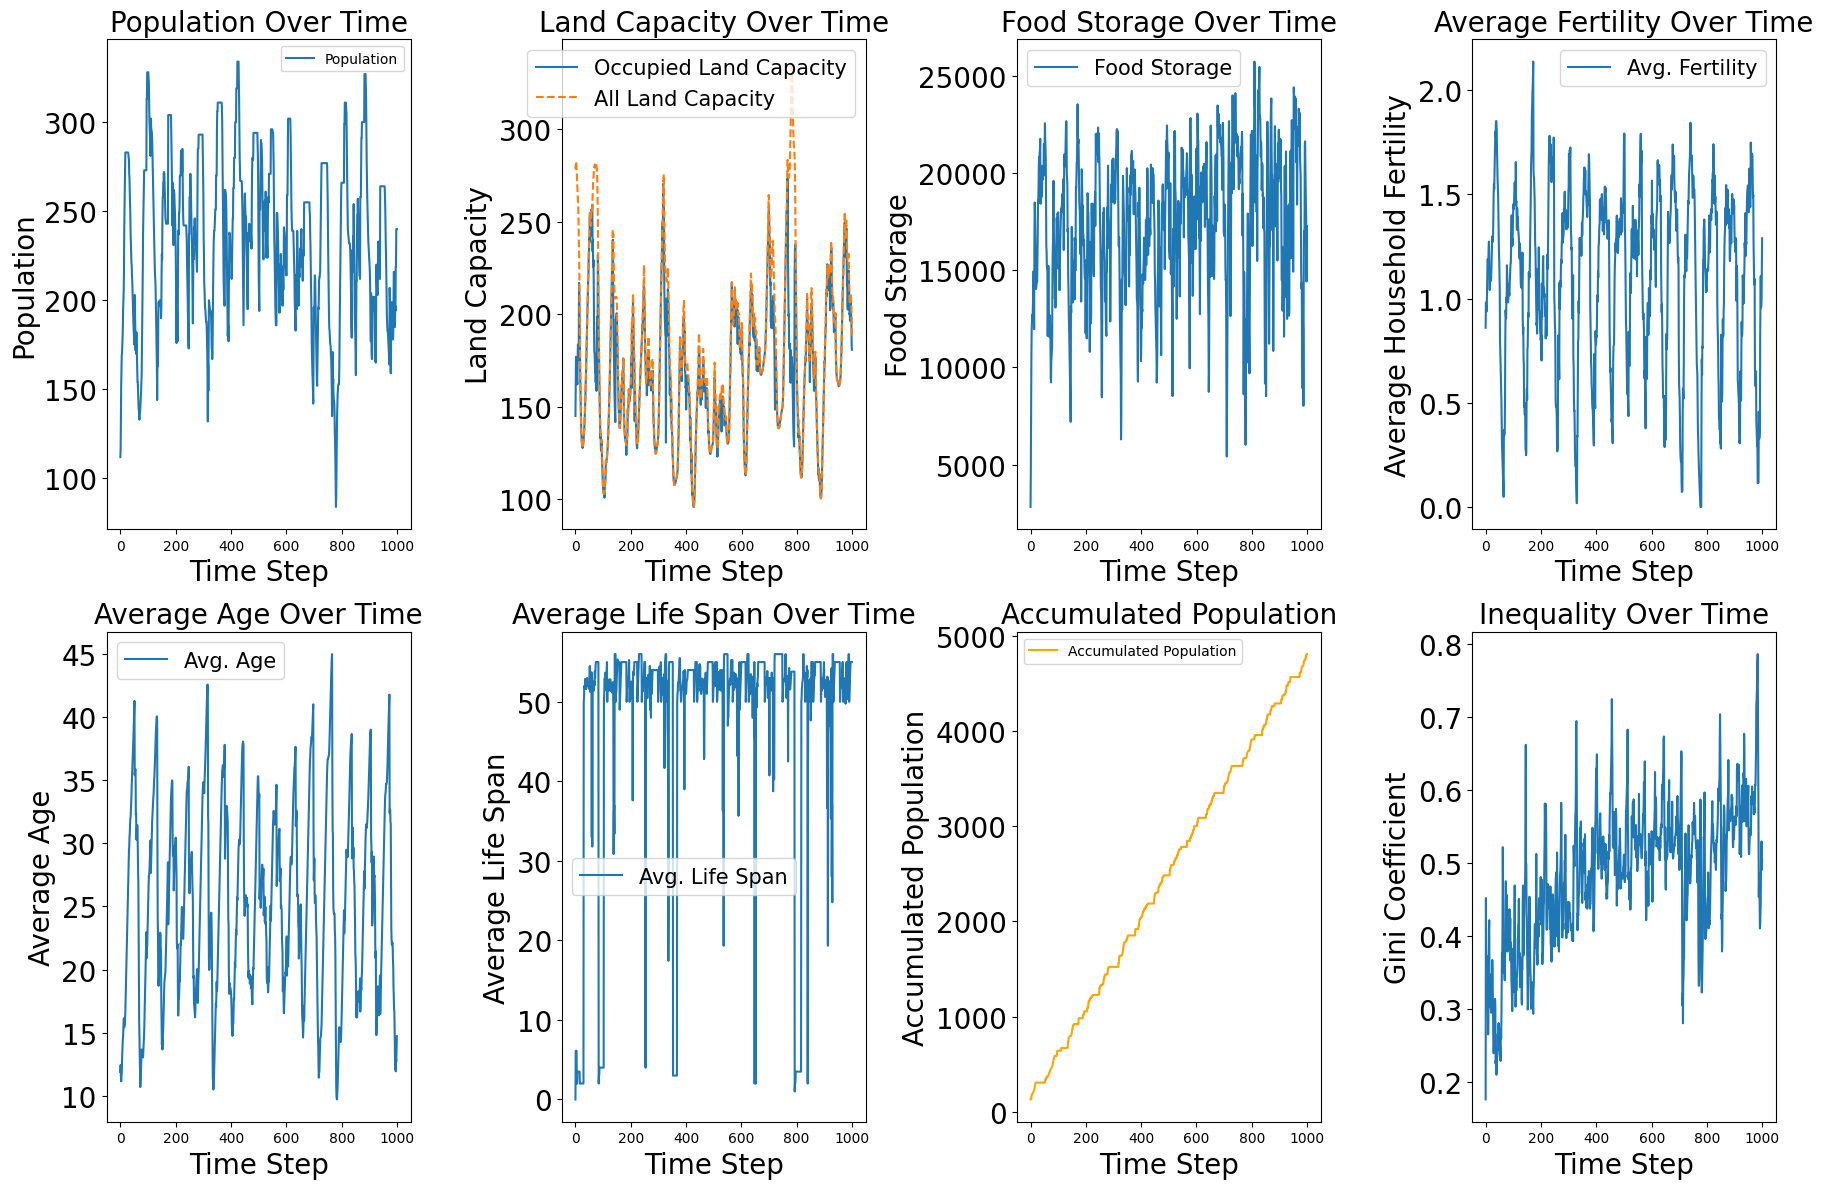

In [1]:
%run demog_scale.py
from variables import *
import variables
import scipy.special as sp
import scipy.linalg as sl
import os
import datetime
from IPython.display import clear_output
timestamp = datetime.datetime.now().strftime("%d-%m-%Y&%H-%M-%S")
folder_name = f"run_results/{timestamp}"

variables.file_name = f"{folder_name}/{variables.file_name}"
variables.file_path = f"{folder_name}/{variables.file_path}"
variables.file_name_csv = f"{folder_name}/{variables.file_name_csv}"

os.makedirs(folder_name, exist_ok=True)
with open(os.path.join(folder_name, "parameters.json"), "w") as f:
    json.dump(params, f, indent=4)
    
%run main.py